# The Decorator Paradigm for Responsive Plotting Functions

[![DOI](https://zenodo.org/badge/214871831.svg)](https://zenodo.org/badge/latestdoi/214871831)

In [1]:
r"""markdown
    TITLE   : The Decorator Paradigm for Responsive Plots
    AUTHOR  : Nathaniel Starkman
    PROJECT : 2019-10-22 dotAstronomy Plotting Workshop
""";

__author__ = 'Nathaniel Starkman'
__version__ = "Oct 22, 2019"

Decorators are an easy and powerful way to modify and extend functions. If you are unfamiliar with decorators, check out the *making_decorators* notebook under `/references/making_decorators.ipynb`

In this notebook I will outline why plotting decorators are the best way to augment plotting functions.  
This technique will allow you to rapidly build complex plotting functions, incorporate those functions into classes and other objects, and still make the plots responsive.

Let's get started.

<br><br>

- - - 
- - - 

<br>

# Prepare

## Imports

In [28]:
import functools
import numpy as np
from astropy import units as u
from matplotlib import pyplot as plt

from astropy.visualization import astropy_mpl_style, quantity_support
quantity_support()
plt.style.use(astropy_mpl_style)

## Functions

Defining a base class for decorators. This just makes decorator creation much simpler. For details, see the *making_decorators* notebook under `/references/making_decorators.ipynb`



In [21]:
class DecoratorClassBase():
    """
    """
    
    @staticmethod
    def _doc_func(docstring):
        return docstring

    def __new__(cls, func=None, **kwargs):
        """
        this is a quick and dirty method for class-based decorator creation
        it is generically better to do this with a classmethod like
        @classmethod
        as_decorator(cls, func=None, ...):
            all the same code as here
        """
        # make instance
        self = super().__new__(cls)
        
        # wrapper control:
        if func is not None:  # this will return a wrapped function
            # pass all arguments and kwargs to init
            # since __init__ is will not be called
            self.__init__(func, **kwargs)
            return self(func)
        else:  # this will return a function wrapper
            # for when using as a @decorator
            # __init__ will be automatically called after this
            return self
    # /def

    def __init__(self, func=None, **kwargs):
        """
        these are stored to be used inside of __call__
        they are not normally passed to the wrapped_function
        """

        # store all values passed to __init__
        for k, v in kwargs.items():
            setattr(self, k, v)
    # /def

    def edit_docstring(self, wrapper):
        """blank call
        """

        # docstring
        if wrapper.__doc__ is not None:
            wrapper.__doc__ = self._doc_func(wrapper.__doc__)

        # storing extra info
        wrapper._doc_func = self._doc_func
        
        return wrapper
    # /def
# /class

## Data

Creating some data to plot.

In [22]:
x = np.linspace(0, 2*np.pi, num=100) * u.s
y = np.cos(x * u.rad / u.s) * u.m

<br><br>

- - - 
- - - 

<br>

# Scripting Plots

The simplest way to plot with Matplotlib is to script plots.
This can be done with either the Matlab script paradigm, or with an object-oriented paradigm.
Here, for clarity and quality we use the object-oriented approach.

Text(0.5, 1.0, 'This is a Title')

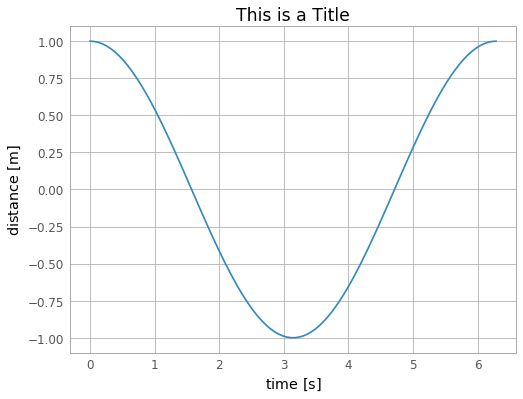

In [29]:
fig, ax = plt.subplots()
ax.plot(x, y)
ax.set_xlabel(f'time [{ax.get_xlabel()}]')
ax.set_ylabel(f'distance [{ax.get_ylabel()}]')
ax.set_title('This is a Title')

This technique is fine for prototyping a plot: every step is spelled out and each component may be adjusted.
However, this script will product one, and only one, plot. If we want to make many plots than scripts must be turned into functions...

# Plotting Functions

Now we are making simple plotting functions. All we have done is embed the above script inside a function called `plot_distance`.
Provided an *x* and *y*, `plot_distance` will produce a plot of *x* vs *y*, titled 'This is a Title', with axis labels 'time [s]' and 'distance [m]', respectively.

In [34]:
# defining function
def plot_distance(x, y):
    fig, ax = plt.subplots()
    ax.plot(x, y)
    ax.set_xlabel(f'time [{ax.get_xlabel()}]')
    ax.set_ylabel(f'distance [{ax.get_ylabel()}]')
    ax.set_title('This is a Title')
    return fig, ax

Calling the function,

(<Figure size 576x432 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x12045b588>)

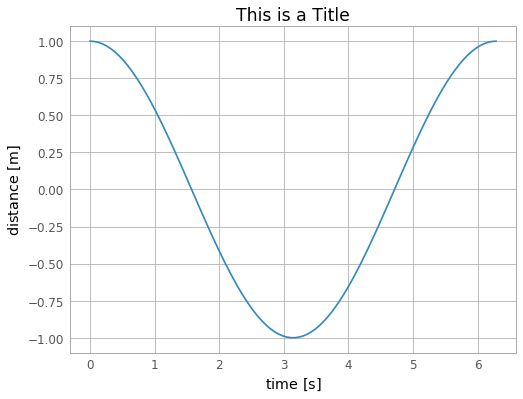

In [32]:
plot_distance(x, y)

We can call the function again, with different inputs. In comparison to the script, this is rather responsive.

(<Figure size 576x432 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x1200da5c0>)

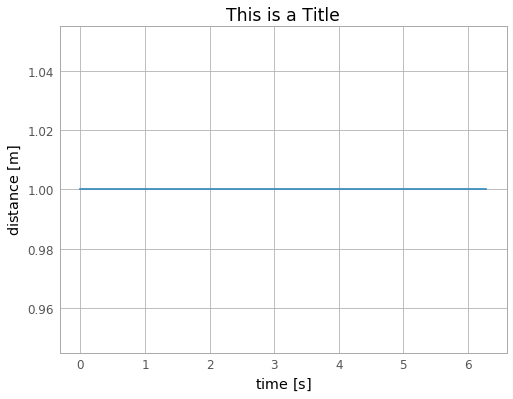

In [38]:
plot_distance(x, y/y*y.unit)

However, this function will only ever make this plot. The axis labels and title are fixed.  
Moreover, the function as written assumes that x and y have units attached.  
What if x, y don't have units attached?

(<Figure size 432x288 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x11ecd2c50>)

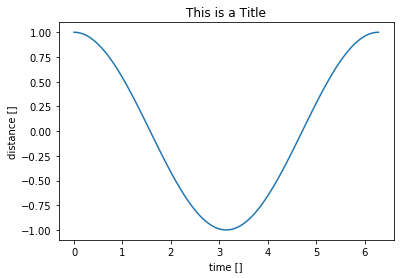

In [8]:
plot_distance(x.value, y.value)

The axis labels look pretty silly.

In principle we can address the labels and title by adding a bunch of options to the plotting function and giving it a few `if` statements to handle the different scenarios.
If fact, I'm going to do one better and even provide the option of specifying the Axes onto which to plot.

In [9]:
def plot_distance_custom(x, y, ax=None, has_units=True, title=''):
    if ax is None:
        fig, ax = plt.subplots()

    ax.plot(x, y)
    
    if has_units:
        ax.set_xlabel(f'time [{ax.get_xlabel()}]')
        ax.set_ylabel(f'distance [{ax.get_ylabel()}]')
    else:
        ax.set_xlabel(f'time')
        ax.set_ylabel(f'distance')

    ax.set_title(title)
    return fig, ax

Testing this out

(<Figure size 432x288 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x11ed44f60>)

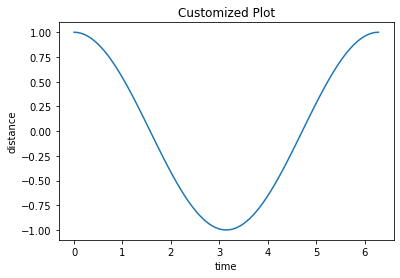

In [10]:
plot_distance_custom(x.value, y.value, ax=None, has_units=False, title='Customized Plot')

Great, now this is a responsive function!

But what if we want to define a new function, `plot_distance_squared`?  

We have to go through this rigamarole all over again.

```python
def plot_distance_squared_custom(x, y, ax=None, has_units=True, title=''):
    if ax is None:
        fig, ax = plt.subplots()

    ax.plot(x, y**2)
    
    if has_units:
        ax.set_xlabel(f'time [{ax.get_xlabel()}]')
        ax.set_ylabel(f'distance [{ax.get_ylabel()}]')
    else:
        ax.set_xlabel(f'time')
        ax.set_ylabel(f'distance')

    ax.set_title(title)
    return fig, ax
```

There has to be a way to write the function `plot_distance_squared` without the hassle of rewriting all the plotting options.

What if we could make something that took care of all the plotting options and we could apply that to the functions we want to write? Wouldn't that be nice?

This magical beast (can) exist and it is called a **decorator**.


# Let There Be Decorators

Here we will define a simple decorator that takes care of the axes, the units, the title, and saving the figure.

Essentially, all the annoying `if` statements and axes shenanigans are controlled by this decorator. We can even add the relevant documentation for our added features to whatever function we are decorating. This is set in the `_addded doc`.


In [44]:
_added_doc = """
Decorator
-------
ax: Axes (default None)
    will make new axes if None
has_units: bool
    whether the arguments have units
title: str
    the title
return_ax: bool
    whether to return the axes
savefig: str, list
    save locations
    can save to many locations if list of strs
"""


class FigureDecorator(DecoratorClassBase):
    """this is a new decorator
    all we need to do is inherit from DecoratorClassBase,
    define a _doc_func and make our wrapper function
    """

    @staticmethod
    def _doc_func(docstring):
        return docstring + _added_doc
    
    def __call__(self, wrapped_function):
        """construct a function wrapper
        """
        @functools.wraps(wrapped_function)
        def wrapper(*func_args, ax=None, xlabel=None, ylabel=None, has_units=True, title=None, return_ax=False, savefig=None, **func_kwargs):

            if ax is None:  # setting new axes
                fig, ax = plt.subplots()
            else:
                plt.sca(ax)
            
            # calling function
            return_ = wrapped_function(*func_args, **func_kwargs)
            
            if has_units:
                ax.set_xlabel(f'{self.xlabel if xlabel is None else xlabel} [{ax.get_xlabel()}]')
                ax.set_ylabel(f'{self.ylabel if ylabel is None else ylabel} [{ax.get_ylabel()}]')
            else:
                ax.set_xlabel(f'{self.xlabel if xlabel is None else xlabel}')
                ax.set_ylabel(f'{self.ylabel if ylabel is None else ylabel}')
            
            if title is None and hasattr(self, 'title'):
                    ax.set_title(self.title)
            else:
                ax.set_title(title)
                
            if savefig is not None:
                if isinstance(savefig, str):
                    plt.savefig(savefig)
                else:
                    for sf in savefig:
                        plt.savefig(sf)

            if return_ax:
                return return_, ax
            return return_
        # /def

        return self.edit_docstring(wrapper)
    # /def



Defining the `plot_distance` and `plot_distance_squared` functions, this time applying the decorators.

In [51]:
@FigureDecorator(xlabel='time', ylabel='distance', title='default title')
def plot_distance_dec(x, y):
    plt.plot(x, y)
    
    
@FigureDecorator(xlabel='time', ylabel='distance^2', title='another default title')
def plot_distance_squared_dec(x, y):
    plt.plot(x, y * y)

Now these functions have all the power of `FigureDecorator`. They will accept as key-word arguments: `ax`, `xlabel`, `ylabel`, `has_units`, `title`, `return_ax`, `savefig`. 

To see this in action,

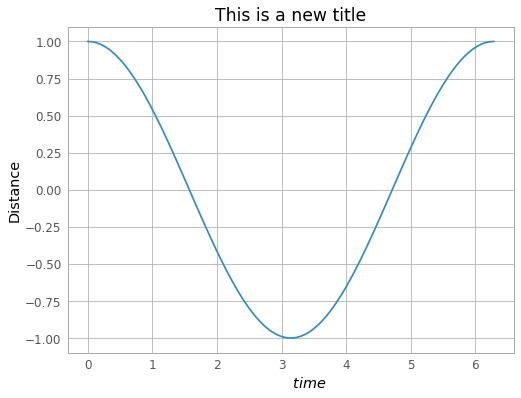

In [52]:
plot_distance_dec(x, y, title='This is a new title', xlabel='        $time$', ylabel='Distance', has_units=False)

It works! We can now override the properties of the plot quite easily.

To see a cooler example in action, the `ax` argument means that plotting functions can be applied to subplots.

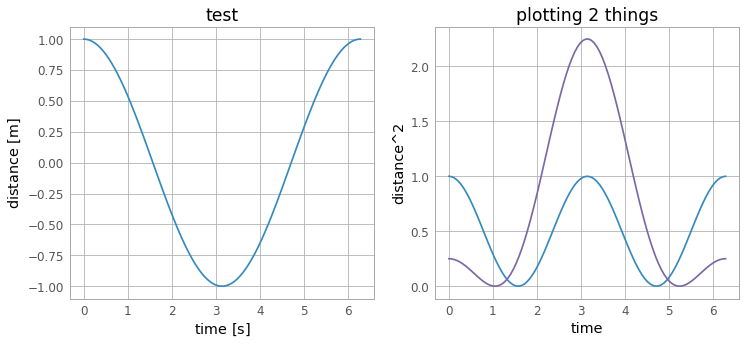

In [68]:
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

plot_distance_dec(x, y, ax=axs[0], title='test')
plot_distance_squared_dec(x, y, ax=axs[1])
plot_distance_squared_dec(x, y-.5* y.unit, ax=axs[1], has_units=False, title='plotting 2 things')

The functions could also have been built via the function call syntax -- `new_func = decorator(old_func, **options)`.

This allows existing and undecorated functions to be turned into our new, reponsive plotting functions.

In [77]:
def simple_plot_distance(x, y):
    """An unresponsive function"""
    plt.plot(x, y)
    plt.xlabel(f'time [{plt.gca().get_xlabel()}]')
    plt.ylabel(f'distance [{plt.gca().get_ylabel()}]')
    plt.title('This is a Title')
    return

plot_distance_comparison = FigureDecorator(simple_plot_distance, xlabel='time', ylabel='distance', title='default title')

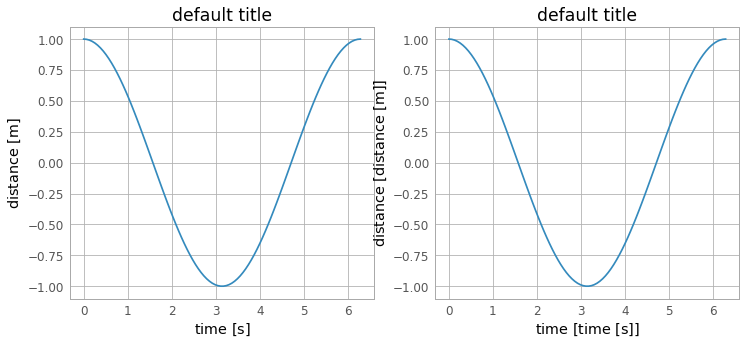

In [78]:
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

plot_distance_dec(x, y, ax=axs[0])
plot_distance_comparison(x, y, ax=axs[1])

This decorator also adds the nice feature of allowing multiple save locations.

In [18]:
plot_distance_dec(x, y, title='overridden title', savefig=('../figures/decorator_plot_save1', '../figures/decorator_plot_save2'))
plt.close();

Showing the second save (`../figures/loc2.png`)

![](../figures/decorator_plot_save2.png)

This was just a short preview. With decorators we can do so much more: apply mpld3, widgets, side histograms, plotly plots, etc.

I have been (slowly) developing a package called `starkplot` that implements this decorator-based paradigm. Check it out [here](https://github.com/nstarman/starkplot)

<br><br>

- - - 
- - - 

<span style='font-size:40px;font-weight:650'>
    END
</span>